In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [2]:
#  read data from json file
path = './data/intervals_challenge.json'
travel_time = pd.read_json(path,lines=True)

In [3]:
travel_time.head()

,duration,distance,started_at,trip_id,vehicle_id,city_id,type
0,857,5384,2016-10-03 13:00:00.286999941,c00cee6963e0dc66e50e271239426914,52d38cf1a3240d5cbdcf730f2d9a47d6,pentos,driving_to_destination
1,245,1248,2016-10-03 13:00:00.852999926,427425e1f4318ca2461168bdd6e4fcbd,8336b28f24c3e7a1e3d582073b164895,volantis,going_to_pickup
2,1249,5847,2016-10-03 13:00:01.670000076,757867f6d7c00ef92a65bfaa3895943f,8885c59374cc539163e83f01ed59fd16,pentos,driving_to_destination
3,471,2585,2016-10-03 13:00:01.841000080,d09d1301d361f7359d0d936557d10f89,81b63920454f70b6755a494e3b28b3a7,bravos,going_to_pickup
4,182,743,2016-10-03 13:00:01.970000029,00f20a701f0ec2519353ef3ffaf75068,b73030977cbad61c9db55418909864fa,pentos,going_to_pickup


In [4]:
travel_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165170 entries, 0 to 165169
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   duration    165170 non-null  object        
 1   distance    165170 non-null  object        
 2   started_at  165170 non-null  datetime64[ns]
 3   trip_id     165170 non-null  object        
 4   vehicle_id  165170 non-null  object        
 5   city_id     165170 non-null  object        
 6   type        165170 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 8.8+ MB


In [5]:
# transform duration and distance to integer for scatter data plot
# first extract NA strings and check if their arrays coincide
idx_dura_na = travel_time.duration == 'NA'
idx_dist_na = travel_time.distance == 'NA'
print(np.array_equal(idx_dura_na,idx_dist_na))

travel_clean = travel_time[~idx_dura_na].reset_index()
travel_clean[['duration', 'distance']] = travel_clean[['duration', 'distance']].apply(pd.to_numeric)

True


As I understand from the tech challenge, the different methods that are tested for measuring time depending on distance are used in the incoming trips, therefore, I will analyse only the `going_to_pickup`part of the dataset.

In [6]:
# now keep only 'going to pickup', which are the tested journeys
idx_2pickup = travel_clean.type == 'going_to_pickup'
travel_2pickup = travel_clean[idx_2pickup].reset_index()

# add trip identifier for road (True) or linear (False) distance test
travel_2pickup['exp_id'] = [True if re.findall('^[0-8]',elem) else False for elem in travel_2pickup.trip_id]

I will plot scatter data - distance vs duration - for each city pickup trips, separating in colors the different *linear* or *road* measurement.

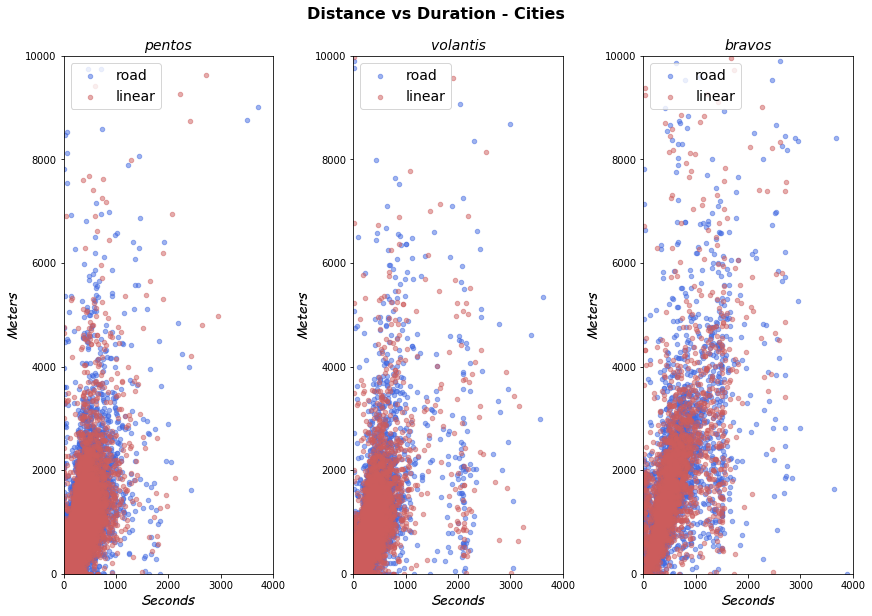

In [7]:
# plot scatter data per city
labels = ['pentos','volantis','bravos']
colorDot = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle('Distance vs Duration - Cities', size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

for i in range(len(labels)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(labels[i],fontdict=subtitle_prop)
    
    axis.set_xlim(0,4000)
    axis.set_ylim(0,10000)
    
    idx = travel_2pickup.city_id == labels[i]
    
    # this part could have been done faster with seaborn using the 'hue' option to distinguish data!
    for j in range(len(colorDot)):
        if j == 0:
            idx_exp = idx & travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = idx & ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        plot_var = travel_2pickup[idx_exp].plot.scatter('duration','distance',ax=axis,s=20,c=colorDot[j],
                                                      alpha=0.5,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=2)
    plt.sca(plot_var)
    plt.xlabel('Seconds',fontdict=label_prop)
    plt.ylabel('Meters',fontdict=label_prop)
    

Where the majority of the data is concentrated, we could interpret that the `road` distance can reach further distances for the same amount of time and for a given distance, it would take less time. However, further analysis is required in order to appreciate if this difference is significant. For that reason, in the following I'll proceed with further analysis of the distributions of distances and time durations.

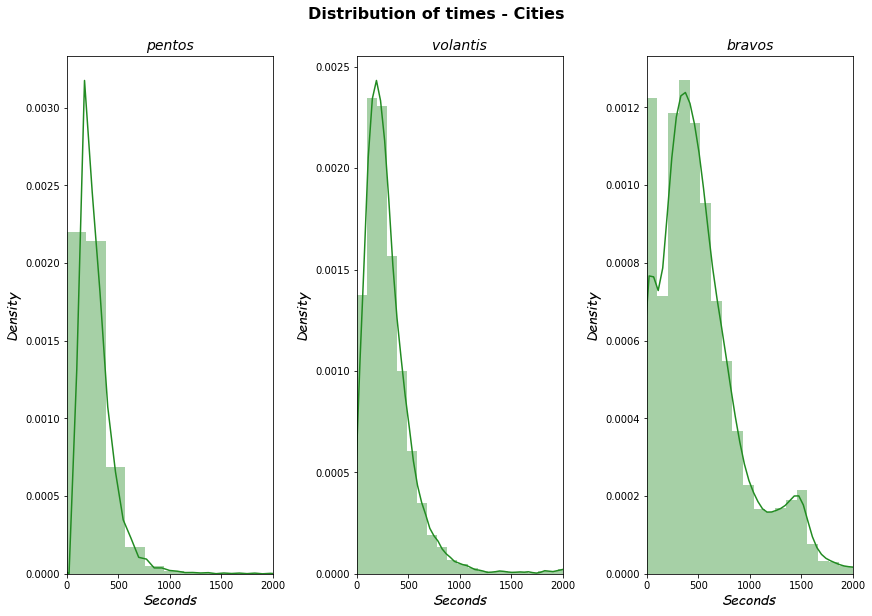

In [8]:
#  See how it is the distribution of times in the three cities

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle('Distribution of times - Cities', size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}

for i in range(len(labels)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(labels[i],fontdict=subtitle_prop)
    
    axis.set_xlim(0,2000)
    
    idx = travel_2pickup.city_id == labels[i]
    
    plot_var = sns.distplot(travel_2pickup[idx].duration,bins=50,color='forestgreen', norm_hist=True)    
    plt.sca(plot_var)
    plt.xlabel('Seconds',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


We could argue that for all cities, the vast majority of the pickup times is below 1000 seconds, to be precise:

In [9]:
# percenage of pickup times below 1000 seconds per city:
for elem in labels:
    idx_city = travel_2pickup.city_id == elem
    idx_time = travel_2pickup.duration <= 1000
    count = (idx_city & idx_time).sum()
    rel_count = count/idx_city.sum()
    print(f"{elem} has {round(rel_count*100,2)} of the pickup times below 1000 seconds")

pentos has 99.4 of the pickup times below 1000 seconds
volantis has 97.35 of the pickup times below 1000 seconds
bravos has 85.98 of the pickup times below 1000 seconds


Now I will focus on some time slots in each city, those that concentrate a significant amount of journeys, and analyze how the distributions of distances, either `road` or `linear`, occur. I am also focusing to extract distances that are very big which indicate possibly bad measurements (speeds over 150 $\frac{km}{h}$).

City pentos has 69.71 % of travels to pickup in time slot <300
Experiment road has 56.4 % of travels in time slot <300
Experiment linear has 43.6 % of travels in time slot <300
City pentos has 26.2 % of travels to pickup in time slot 300-600
Experiment road has 56.34 % of travels in time slot 300-600
Experiment linear has 43.66 % of travels in time slot 300-600
City pentos has 3.15 % of travels to pickup in time slot 600-900
Experiment road has 57.8 % of travels in time slot 600-900
Experiment linear has 42.2 % of travels in time slot 600-900


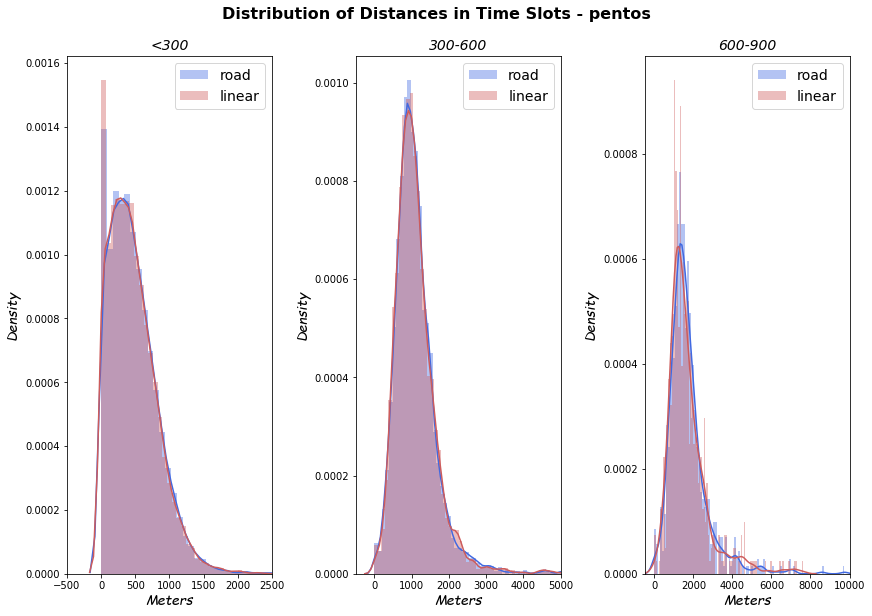

In [10]:
# distribution of distances in the cities for assigned time slots, differentiating either road or linear distances
time_bin = np.array([5, 10, 15])*60
label_bin = [f"<{time_bin[0]}", f"{time_bin[0]}-{time_bin[1]}", f"{time_bin[1]}-{time_bin[2]}"]
city_label = 'pentos'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Distances in Time Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,2500],[-500,5000],[-500,10000]]

for i in range(len(time_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_time = travel_2pickup.duration < time_bin[0]
    else:
        idx_time = (travel_2pickup.duration >= time_bin[i-1]) & (travel_2pickup.duration < time_bin[i])
        
    idx = idx_city & idx_time
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in time slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        # filter values above 10 km (velocities above 150 km/h)
        filt_dist = travel_2pickup[idx_bin_exp].distance
        filt_dist = filt_dist[filt_dist < 10000]
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in time slot {label_bin[i]}")
        
        plot_dist = sns.distplot(filt_dist,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Meters',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


City volantis has 60.16 % of travels to pickup in time slot <300
Experiment road has 58.23 % of travels in time slot <300
Experiment linear has 41.77 % of travels in time slot <300
City volantis has 30.38 % of travels to pickup in time slot 300-600
Experiment road has 56.28 % of travels in time slot 300-600
Experiment linear has 43.72 % of travels in time slot 300-600
City volantis has 6.16 % of travels to pickup in time slot 600-900
Experiment road has 55.87 % of travels in time slot 600-900
Experiment linear has 44.13 % of travels in time slot 600-900


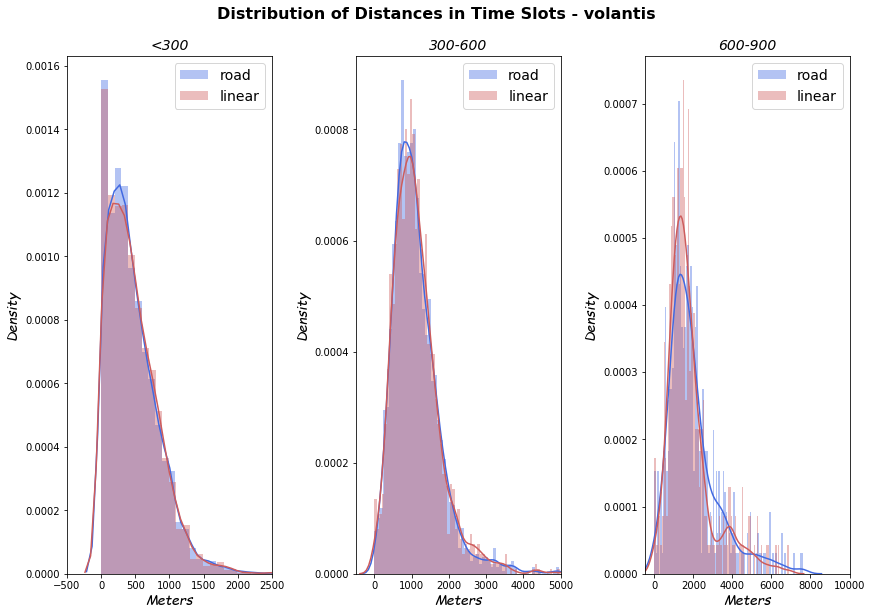

In [11]:
# distribution of distances in the cities for assigned time slots, differentiating either road or linear distances
time_bin = np.array([5, 10, 15])*60
label_bin = [f"<{time_bin[0]}", f"{time_bin[0]}-{time_bin[1]}", f"{time_bin[1]}-{time_bin[2]}"]
city_label = 'volantis'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Distances in Time Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,2500],[-500,5000],[-500,10000]]

for i in range(len(time_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_time = travel_2pickup.duration < time_bin[0]
    else:
        idx_time = (travel_2pickup.duration >= time_bin[i-1]) & (travel_2pickup.duration < time_bin[i])
        
    idx = idx_city & idx_time
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in time slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        # filter values above 10 km (velocities above 150 km/h)
        filt_dist = travel_2pickup[idx_bin_exp].distance
        filt_dist = filt_dist[filt_dist < 10000]
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in time slot {label_bin[i]}")
        
        plot_dist = sns.distplot(filt_dist,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Meters',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


City bravos has 74.45 % of travels to pickup in time slot <720
Experiment road has 56.57 % of travels in time slot <720
Experiment linear has 43.43 % of travels in time slot <720
City bravos has 19.17 % of travels to pickup in time slot 720-1440
Experiment road has 56.04 % of travels in time slot 720-1440
Experiment linear has 43.96 % of travels in time slot 720-1440
City bravos has 4.58 % of travels to pickup in time slot 1440-2160
Experiment road has 56.09 % of travels in time slot 1440-2160
Experiment linear has 43.91 % of travels in time slot 1440-2160


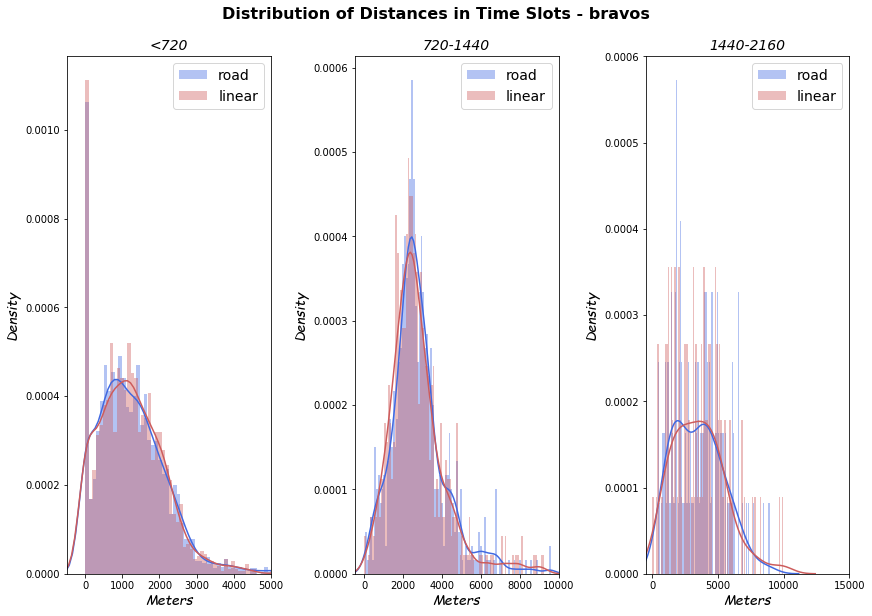

In [12]:
# distribution of distances in the cities for assigned time slots, differentiating either road or linear distances
time_bin = np.array([12, 24, 36])*60
label_bin = [f"<{time_bin[0]}", f"{time_bin[0]}-{time_bin[1]}", f"{time_bin[1]}-{time_bin[2]}"]
city_label = 'bravos'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Distances in Time Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,5000],[-500,10000],[-500,15000]]

for i in range(len(time_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_time = travel_2pickup.duration < time_bin[0]
    else:
        idx_time = (travel_2pickup.duration >= time_bin[i-1]) & (travel_2pickup.duration < time_bin[i])
        
    idx = idx_city & idx_time
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in time slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        # filter values above 10 km (velocities above 150 km/h)
        filt_dist = travel_2pickup[idx_bin_exp].distance
        filt_dist = filt_dist[filt_dist < 10000]
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in time slot {label_bin[i]}")
        
        plot_dist = sns.distplot(filt_dist,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Meters',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


The counter analysis would be the distribution of travel durations for distance slots. This could show if different meassurements allow reaching faster to locations of similar distances.

City pentos has 77.69 % of travels to pickup in distance slot <1000
Experiment road has 56.32 % of travels in distance slot <1000
Experiment linear has 43.68 % of travels in distance slot <1000
City pentos has 21.3 % of travels to pickup in distance slot 1000-3000
Experiment road has 56.77 % of travels in distance slot 1000-3000
Experiment linear has 43.23 % of travels in distance slot 1000-3000
City pentos has 0.84 % of travels to pickup in distance slot 3000-6000
Experiment road has 56.25 % of travels in distance slot 3000-6000
Experiment linear has 43.75 % of travels in distance slot 3000-6000


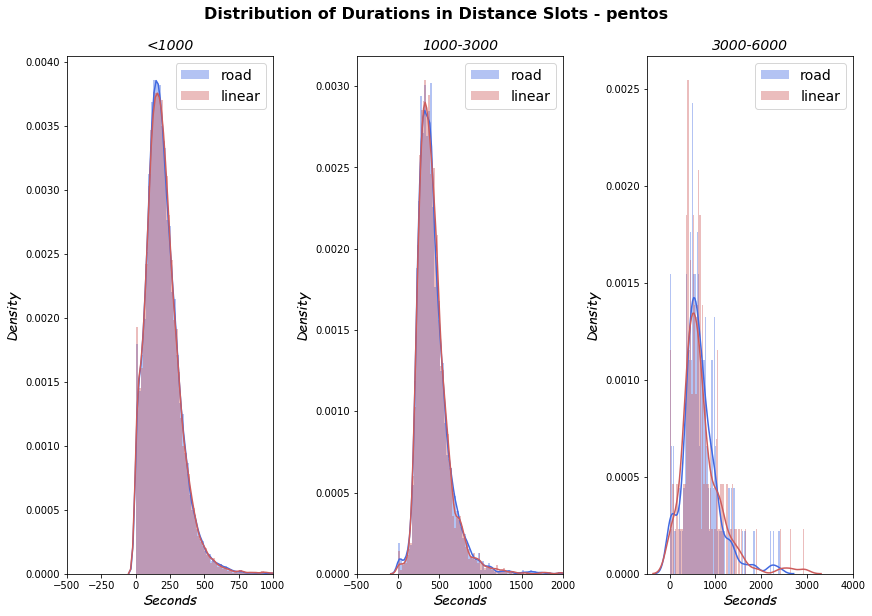

In [13]:
# distribution of duration in the cities for assigned distance slots, differentiating either road or linear measurements
dist_bin = np.array([1, 3, 6])*1000
label_bin = [f"<{dist_bin[0]}", f"{dist_bin[0]}-{dist_bin[1]}", f"{dist_bin[1]}-{dist_bin[2]}"]
city_label = 'pentos'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Durations in Distance Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,1000],[-500,2000],[-500,4000]]

for i in range(len(dist_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_dist = travel_2pickup.distance < dist_bin[0]
    else:
        idx_dist = (travel_2pickup.distance >= dist_bin[i-1]) & (travel_2pickup.distance < dist_bin[i])
        
    idx = idx_city & idx_dist
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in distance slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in distance slot {label_bin[i]}")
        
        plot_dist = sns.distplot(travel_2pickup[idx_bin_exp].duration,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Seconds',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


City volantis has 71.23 % of travels to pickup in distance slot <1000
Experiment road has 57.77 % of travels in distance slot <1000
Experiment linear has 42.23 % of travels in distance slot <1000
City volantis has 25.73 % of travels to pickup in distance slot 1000-3000
Experiment road has 56.28 % of travels in distance slot 1000-3000
Experiment linear has 43.72 % of travels in distance slot 1000-3000
City volantis has 2.47 % of travels to pickup in distance slot 3000-6000
Experiment road has 58.31 % of travels in distance slot 3000-6000
Experiment linear has 41.69 % of travels in distance slot 3000-6000


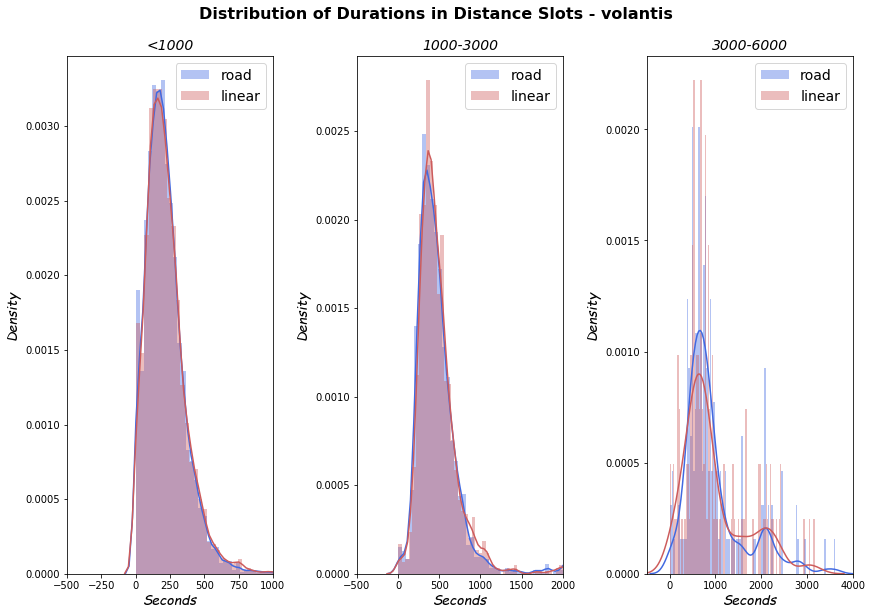

In [14]:
# distribution of duration in the cities for assigned distance slots, differentiating either road or linear measurements
dist_bin = np.array([1, 3, 6])*1000
label_bin = [f"<{dist_bin[0]}", f"{dist_bin[0]}-{dist_bin[1]}", f"{dist_bin[1]}-{dist_bin[2]}"]
city_label = 'volantis'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Durations in Distance Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,1000],[-500,2000],[-500,4000]]

for i in range(len(dist_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_dist = travel_2pickup.distance < dist_bin[0]
    else:
        idx_dist = (travel_2pickup.distance >= dist_bin[i-1]) & (travel_2pickup.distance < dist_bin[i])
        
    idx = idx_city & idx_dist
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in distance slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in distance slot {label_bin[i]}")
        
        plot_dist = sns.distplot(travel_2pickup[idx_bin_exp].duration,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Seconds',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


City bravos has 33.91 % of travels to pickup in distance slot <1000
Experiment road has 57.87 % of travels in distance slot <1000
Experiment linear has 42.13 % of travels in distance slot <1000
City bravos has 51.59 % of travels to pickup in distance slot 1000-3000
Experiment road has 55.55 % of travels in distance slot 1000-3000
Experiment linear has 44.45 % of travels in distance slot 1000-3000
City bravos has 10.67 % of travels to pickup in distance slot 3000-6000
Experiment road has 57.44 % of travels in distance slot 3000-6000
Experiment linear has 42.56 % of travels in distance slot 3000-6000


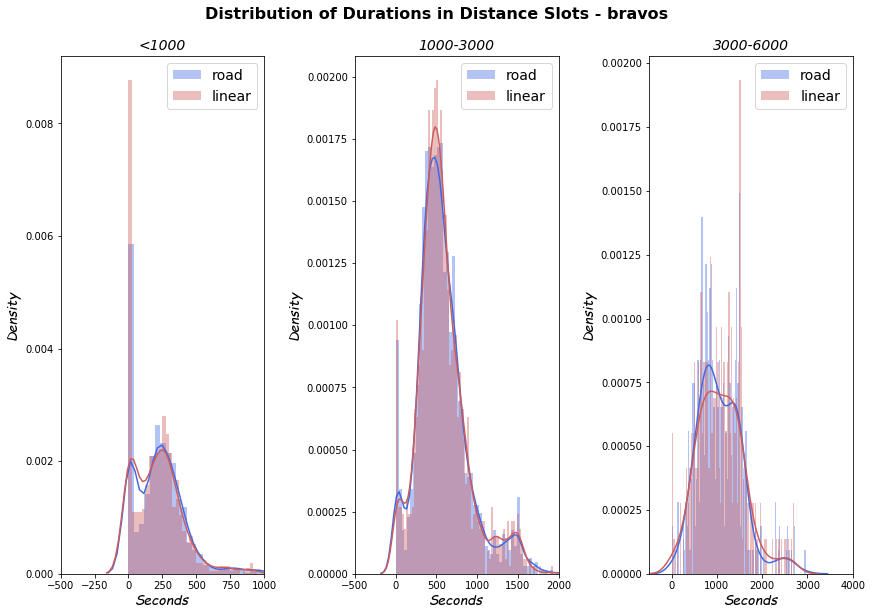

In [15]:
# distribution of duration in the cities for assigned distance slots, differentiating either road or linear measurements
dist_bin = np.array([1, 3, 6])*1000
label_bin = [f"<{dist_bin[0]}", f"{dist_bin[0]}-{dist_bin[1]}", f"{dist_bin[1]}-{dist_bin[2]}"]
city_label = 'bravos'
idx_city = travel_2pickup.city_id == city_label
colorDist = ['royalblue','indianred']

# prepare figure
fig = plt.figure(figsize=[12,8],constrained_layout=True)
fig.suptitle(f"Distribution of Durations in Distance Slots - {city_label}", size=16, weight='bold',y=1.05)
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
subtitle_prop = {'size':14,'style':'oblique'}
label_prop = {'size':14,'family':'fantasy','style':'oblique'}
legend_prop = {'size':14,'weight':'ultralight'}

# x-axis lims
x_axis_lim = [[-500,1000],[-500,2000],[-500,4000]]

for i in range(len(dist_bin)):
    axis = fig.add_subplot(spec[0,i])
    axis.set_title(label_bin[i],fontdict=subtitle_prop)
    axis.set_xlim(x_axis_lim[i][0],x_axis_lim[i][1])
    
    if i == 0:
        idx_dist = travel_2pickup.distance < dist_bin[0]
    else:
        idx_dist = (travel_2pickup.distance >= dist_bin[i-1]) & (travel_2pickup.distance < dist_bin[i])
        
    idx = idx_city & idx_dist
    bin_prop = idx.sum()/idx_city.sum()
    print(f"City {city_label} has {round(bin_prop*100,2)} % of travels to pickup in distance slot {label_bin[i]}")
    
    for j in range(len(colorDist)):
        if j == 0:
            idx_exp = travel_2pickup.exp_id
            exp_label = 'road'
        else:
            idx_exp = ~travel_2pickup.exp_id
            exp_label = 'linear'
        
        idx_bin_exp = idx & idx_exp
        exp_prop = idx_bin_exp.sum()/idx.sum()
        print(f"Experiment {exp_label} has {round(exp_prop*100,2)} % of travels in distance slot {label_bin[i]}")
        
        plot_dist = sns.distplot(travel_2pickup[idx_bin_exp].duration,bins=100,color=colorDist[j],
                                 norm_hist=True,ax=axis,label=exp_label)
    
    axis.legend(prop=legend_prop,loc=1)
    plt.sca(plot_dist)
    plt.xlabel('Seconds',fontdict=label_prop)
    plt.ylabel('Density',fontdict=label_prop)


* In conclusion, neither the distributions of travel distances nor the distributions of travel durations obtained for the two systems of measurement show that there is statistical significance between the two.
* However, it is true that in particular cities, the status of the traffic is a key element to decide how to assign vehicles.
* Thus, the `road` distance would make a big different not for the average calls but in case of particular traffic events.
* A proposition would be to use a system of calls that instead of asking always the API uses instead the `linear` system and checks it every certain amount of time for traffic incidents and only switch in those cases.
* The price of the API calls can be costed using a percentage of the commission that we are gaining for each travel. We could take the median of these commissions and decide within the company which percentage is a proper value to assign for this cost.
* The experimental design could be improved considering each city as a particular case, adding more data to capture different traffic accidents for a longer period than 5 days and targeting the rush hours and analyzing them as special cases.